### Tensorflow Cuda Tests
Test to make sure if graphics card is working. And AVX-xxx is configured correctly. 
Otherwise work on your build. ;)

In [1]:
# Imports
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from numba import cuda 
import os

import time

# Remarks to
# https://www.tensorflow.org/api_docs/python/tf/test/is_gpu_available
# https://stackoverflow.com/questions/38009682/how-to-tell-if-tensorflow-is-using-gpu-acceleration-from-inside-python-shell
# https://www.analyticsvidhya.com/blog/2021/11/benchmarking-cpu-and-gpu-performance-with-tensorflow/
# https://stackoverflow.com/questions/64997553/python-requires-ipykernel-to-be-installed
# https://stackoverflow.com/questions/65124633/line-magic-function-time-not-found
# https://stackoverflow.com/questions/39758094/clearing-tensorflow-gpu-memory-after-model-execution
# https://stackoverflow.com/questions/43332703/open-terminal-run-command-python

In [2]:
# Free Memory
device = cuda.get_current_device()
device.reset()

# Open 2 Bash windows with GPU usage and cpu usage
# GPU
os.system("gnome-terminal -e 'bash -c \"nvidia-smi -l 1; sleep 1000000\" '")

# CPU
os.system("gnome-terminal -e 'bash -c \"mpstat 5; sleep 1000000\" '")

# Ram
os.system("gnome-terminal -e 'bash -c \" free -m -h -s 4; sleep 1000000\" '")

0

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
print("Number GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Number GPUs Available:  1


## Test/Benchmark
Simple training of cifar. 

In [5]:
# Import split
(X_train, y_train), (X_test, y_test) = keras.datasets.cifar10.load_data()

In [6]:
# checking images shape
X_train.shape, X_test.shape

((50000, 32, 32, 3), (10000, 32, 32, 3))

In [7]:
# display single image shape
X_train[0].shape

(32, 32, 3)

In [8]:
# checking labels
y_train[:5]

array([[6],
       [9],
       [9],
       [4],
       [1]], dtype=uint8)

In [9]:
# scaling image values between 0-1
X_train_scaled = X_train/255
X_test_scaled = X_test/255

# one hot encoding labels
y_train_encoded = keras.utils.to_categorical(y_train, num_classes = 10, dtype = 'float32')
y_test_encoded = keras.utils.to_categorical(y_test, num_classes = 10, dtype = 'float32')

In [10]:
# Model
def get_model():
    model = keras.Sequential([
        keras.layers.Flatten(input_shape=(32,32,3)),
        keras.layers.Dense(3000, activation='relu'),
        keras.layers.Dense(1000, activation='relu'),
        keras.layers.Dense(10, activation='sigmoid')    
    ])
    model.compile(optimizer='SGD',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    return model

#### Benchmark Section 

In [11]:
# Variables
_epochs = 10

In [12]:
# Timer
start = time.time()
# CPU
with tf.device('/CPU:0'):
    model_cpu = get_model()
    model_cpu.fit(X_train_scaled, y_train_encoded, epochs = _epochs)

end = time.time()
cpu_time = end - start

Epoch 1/10
1563/1563 [==============================] - 32s 20ms/step - loss: 1.8148 - accuracy: 0.3540
Epoch 2/10
1563/1563 [==============================] - 32s 20ms/step - loss: 1.6285 - accuracy: 0.4231
Epoch 3/10
1563/1563 [==============================] - 32s 20ms/step - loss: 1.5437 - accuracy: 0.4564
Epoch 4/10
1563/1563 [==============================] - 32s 20ms/step - loss: 1.4829 - accuracy: 0.4762
Epoch 5/10
1563/1563 [==============================] - 32s 20ms/step - loss: 1.4349 - accuracy: 0.4949
Epoch 6/10
1563/1563 [==============================] - 32s 20ms/step - loss: 1.3912 - accuracy: 0.5101
Epoch 7/10
1563/1563 [==============================] - 33s 21ms/step - loss: 1.3520 - accuracy: 0.5265
Epoch 8/10
1563/1563 [==============================] - 31s 20ms/step - loss: 1.3178 - accuracy: 0.5344
Epoch 9/10
1563/1563 [==============================] - 31s 20ms/step - loss: 1.2848 - accuracy: 0.5509
Epoch 10/10
1563/1563 [==============================] - 30s 19m

In [13]:
# Timer
start = time.time()

# GPU
with tf.device('/GPU:0'):
    model_gpu = get_model()
    model_gpu.fit(X_train_scaled, y_train_encoded, epochs = _epochs)

end = time.time()
gpu_time = end - start

Epoch 1/10
1563/1563 [==============================] - 8s 4ms/step - loss: 1.8167 - accuracy: 0.3531
Epoch 2/10
1563/1563 [==============================] - 7s 4ms/step - loss: 1.6304 - accuracy: 0.4250
Epoch 3/10
1563/1563 [==============================] - 7s 4ms/step - loss: 1.5466 - accuracy: 0.4538
Epoch 4/10
1563/1563 [==============================] - 7s 4ms/step - loss: 1.4852 - accuracy: 0.4762
Epoch 5/10
1563/1563 [==============================] - 7s 4ms/step - loss: 1.4386 - accuracy: 0.4918
Epoch 6/10
1563/1563 [==============================] - 7s 4ms/step - loss: 1.3933 - accuracy: 0.5109
Epoch 7/10
1563/1563 [==============================] - 7s 4ms/step - loss: 1.3555 - accuracy: 0.5248
Epoch 8/10
1563/1563 [==============================] - 7s 4ms/step - loss: 1.3199 - accuracy: 0.5340
Epoch 9/10
1563/1563 [==============================] - 7s 4ms/step - loss: 1.2868 - accuracy: 0.5473
Epoch 10/10
1563/1563 [==============================] - 7s 4ms/step - loss: 1.257

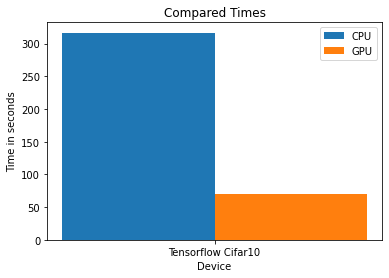

In [18]:
# Plot
X = ["Tensorflow Cifar10"]
  
X_axis = np.arange(len(X))
  
plt.bar(X_axis - 0.2, cpu_time, 0.4, label = 'CPU')
plt.bar(X_axis + 0.2, gpu_time, 0.4, label = 'GPU')
  
plt.xticks(X_axis, X)
plt.xlabel("Device")
plt.ylabel("Time in seconds")
plt.title("Compared Times")
plt.legend()
plt.show()

In [15]:
# Free Memory
device = cuda.get_current_device()
device.reset()